In [3]:
import numpy as np
import time

In [166]:
class RobotController:
    def __init__(self, Kp, Ki, dt=0.1, wheel_radius = 0.028, wheel_sep = 0.222, integral_windup=True, real_time=True):
        self.Kp = Kp            # Proportional gain
        self.Ki = Ki            # Integral gain
        self.dt = dt            # Time step
        
        self.r = wheel_radius
        self.l = wheel_sep
        
        self.min_output = -100  # Minimum duty cycle (-100%)
        self.max_output = 100  # Maximum duty cycle (100%)
        
        self.ml_integral = 0       # Integral term, motor left
        self.mr_integral = 0       # Integral term, motor right
        self.ml_last_update, self.mr_last_update = None, None  # Last update time

        self.anti_integral_windup = integral_windup  # Anti-windup flag
        self.real_time = real_time

    """
    Gets the time of the last measurement/update for the motor ml or mr
    """
    def get_dt(self, motor=None):
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")

        if not self.real_time:
            return self.dt
        
        last_update = f"{motor}_last_update"
        now = time.time()
        print(f"Last update: {getattr(self, last_update)}")
        if getattr(self, last_update) is None:
            setattr(self, last_update, now)
            return self.dt
        
        dt = now - getattr(self, last_update)
        setattr(self, last_update, now)
        return dt


    def compute(self, w_target, w_actual, motor=None):
        # motor should be either "ml" or "mr" for left or right motor
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")
        integral_attr = f"{motor}_integral"
        last_update = f"{motor}_last_update"
        
        dt = self.get_dt(motor)
        
        error = w_target - w_actual # Calculate the error
        P_out = self.Kp * error # Proportional term
        I_out = self.Ki * getattr(self,integral_attr) # Integral term
        raw_output = P_out + I_out

        if self.anti_integral_windup:
            # Anti-windup - only integrate if output is not saturated
            if self.min_output < raw_output < self.max_output:
                setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                # equiv. to self.ml_integral += error * self.dt or self.mr_integral += error * self.dt
        else:
            setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                        
            
        return np.clip(raw_output, self.min_output, self.max_output) # Clamp the output to the min/max duty cycle limits
        
    
    def diff_drive_control(self, v_desired, w_desired, wl_actual, wr_actual):
        # v_desired: m/s
        # w_desired (rotation), wl_actual, w_actual (rotation): rad/s
        
        # Calculate desired wheel angular velocities
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        print(f"wl_des (rad/s): {wl_desired:.2f}, wr_des: {wr_desired:.2f}\nwl_des (rps): {wl_desired/(2*np.pi):.2f}, wr_des: {wr_desired/(2*np.pi):.2f}")

        # Compute duty cycles for left and right wheels
        duty_cycle_l = self.compute(wl_desired, wl_actual, 'ml')
        duty_cycle_r = self.compute(wr_desired, wr_actual, 'mr')
        return duty_cycle_l, duty_cycle_r

# Example usage:
# Create a PI controller instance with desired Kp, Ki values and time step
Kp = 0.2  # Proportional gain
Ki = 0.02  # Integral gain
dt = 0.1  # Time step in seconds

controller = RobotController(Kp, Ki, dt)




# Compute the duty cycle to apply to the PWM motor


In [167]:
v_desired = 0.5
w_desired = 0
left_wheel_angvel = 0 # rad/s
right_wheel_angvel = 0 # rad/s

output = controller.compute(200, 200, 'mr')
print(f"Output: {output:.2f}")



duty_cycle_l, duty_cycle_r = controller.diff_drive_control(v_desired, w_desired, left_wheel_angvel, right_wheel_angvel)
print(f"Duty Cycle Left: {duty_cycle_l:.2f}%, Duty Cycle Right: {duty_cycle_r:.2f}%")

Last update: None
Output: 0.00
wl_des (rad/s): 17.86, wr_des: 17.86
wl_des (rps): 2.84, wr_des: 2.84
Last update: None
Last update: 1724581996.051604
Duty Cycle Left: 3.57%, Duty Cycle Right: 3.57%


In [1]:
import threading
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline
plt.ion()  # Turn on interactive mode

class Robot:
    def __init__(self):
        self.position = 0
        self.velocity = 0

    def update(self, control_input):
        self.velocity += control_input
        self.position += self.velocity

class RobotController:
    def __init__(self):
        self.robot = Robot()
        self.time = []
        self.positions = []
        self.velocities = []
        self.running = True

    def control_loop(self):
        start_time = time.time()
        while self.running:
            current_time = time.time() - start_time
            # Simulated control input (e.g., a sine wave)
            control_input = np.sin(current_time)
            
            # Update robot state
            self.robot.update(control_input)
            
            # Store data for plotting
            self.time.append(current_time)
            self.positions.append(self.robot.position)
            self.velocities.append(self.robot.velocity)
            
            # Simulate some processing time
            time.sleep(0.01)

    def start(self):
        self.control_thread = threading.Thread(target=self.control_loop)
        self.control_thread.start()

    def stop(self):
        self.running = False
        self.control_thread.join()

def update_plot(controller, fig, ax1, ax2):
    ax1.clear()
    ax2.clear()
    
    ax1.plot(controller.time, controller.positions)
    ax2.plot(controller.time, controller.velocities)
    
    ax1.set_ylabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_xlabel('Time')
    
    fig.canvas.draw()
    display.clear_output(wait=True)
    display.display(fig)



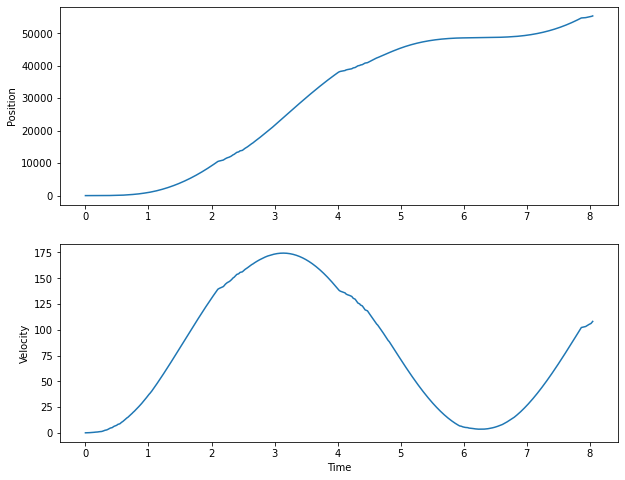

Stopping the simulation...
Simulation ended.


In [2]:
# Create the controller and start the control loop
controller = RobotController()
controller.start()

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Main loop for updating the plot
try:
    while True:
        update_plot(controller, fig, ax1, ax2)
        time.sleep(1)  # Update plot every 0.1 seconds
except KeyboardInterrupt:
    print("Stopping the simulation...")
finally:
    controller.stop()
    plt.close(fig)

print("Simulation ended.")

In [ ]:
import RPi.GPIO as GPIO
import time
GPIO.setwarnings(False)
# Set the GPIO mode
GPIO.setmode(GPIO.BCM)

# Define the pin number
pin = 2  # Change this to your desired pin number

# Set up the pin as an output
GPIO.setup(pin, GPIO.OUT)

# Set the pin to high
GPIO.output(pin, GPIO.HIGH)

# Keep the script running to maintain the pin state
try:
    while True:
        print("running")
        time.sleep(1)
except KeyboardInterrupt:
    # Clean up on exit
    print("Cleanup")
    GPIO.cleanup()

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


running
running
running


In [39]:
max_scan_distance = .8
width = 4.12
num_scan_lines = int(np.ceil((width-(2*max_scan_distance)) / (2*max_scan_distance)))
print(num_scan_lines)
scan_lines = np.linspace(max_scan_distance, width-max_scan_distance, num_scan_lines)
print(scan_lines)

2
[0.8  3.32]
